# Introduction<br>
This research aims to find out which system can better evaluate hitter performance based on measurements of batted ball metrics and make predictions for the upcoming season.

# Method<br>
Decide which one of system A or B is better by<br>
1. Take a look at the scatter plot<br>
2. Take a look at all kinds of classification models and use hittype as dependent variable. After coming up with the best model take a look at which system contributes more in that model.<br>
3. Use SVD to check again which system is better and come up with the prediction for the exit velocity of each batter.<br>
4. Use Randomforestregressor to map the missing value in system A using data from system B. Then use SVD again to come up with another prediction.  

## Step1: Import the data and take a brief look at what we got

In [1]:
import pandas as pd
df_forspeed = pd.read_csv(r'C:\Users\allen\Desktop\TBR\battedBallData.csv')
print(df_forspeed.describe())

             batter       pitcher       speed_A      vangle_A       speed_B  \
count  73375.000000  73375.000000  65803.000000  65803.000000  71973.000000   
mean     365.135005    289.957547     88.425429     10.853558     77.748243   
std      229.816539    186.406565     13.192938     24.024058     18.621538   
min        1.000000      1.000000     26.461824    -91.898629      5.152318   
25%      170.000000    121.000000     80.362652     -5.558918     66.074054   
50%      341.000000    283.000000     90.638747     11.005251     81.886750   
75%      550.000000    447.000000     98.317818     27.404976     92.326944   
max      816.000000    645.000000    121.847456     78.460978    114.403356   

           vangle_B  
count  71973.000000  
mean      13.094305  
std       24.429536  
min      -85.090929  
25%       -4.634815  
50%       10.546230  
75%       28.880589  
max       90.900819  


See how many hittypes are there

In [2]:
df_forspeed.hittype.unique()

array(['ground_ball', 'line_drive', 'fly_ball', 'popup', 'U'],
      dtype=object)

'U' is the obvious weird one here. Check how many 'U' are in the dataset

In [3]:
print(df_forspeed[df_forspeed['hittype']=='U'])

       batter  pitcher hittype    speed_A   vangle_A    speed_B   vangle_B
25540     493      138       U  92.803315  24.403594  89.715655  24.082974
48326     479      228       U        NaN        NaN  60.520107 -22.862289


Turns out there are only two 'U'. Decide to see if the batters(No. 493 No. 479) from these two at bats have enough data in this dataset.

In [4]:
print(df_forspeed[df_forspeed['batter']==493])

       batter  pitcher      hittype     speed_A   vangle_A     speed_B  \
3337      493      171     fly_ball   73.624149  37.087980   70.372879   
3614      493       58   line_drive   90.514656  14.695233   86.064846   
3626      493       58  ground_ball  103.899718  -6.641523  102.525418   
3646      493       58  ground_ball   96.990580 -11.219589   70.207000   
3913      493       17     fly_ball   97.720677  43.451871   95.124047   
...       ...      ...          ...         ...        ...         ...   
39343     493       21   line_drive  108.188709  15.763793  103.321509   
39358     493       21  ground_ball   86.604849  -8.960146   75.785949   
39386     493      254  ground_ball   95.568542   0.316444   90.818482   
39864     493      394  ground_ball   73.323211 -21.383667   50.722591   
39894     493      304  ground_ball         NaN        NaN   53.650751   

        vangle_B  
3337   37.342600  
3614   14.082713  
3626   -5.480336  
3646   -5.701149  
3913   44.615691

In [5]:
print(df_forspeed[df_forspeed['batter']==479])

       batter  pitcher      hittype     speed_A   vangle_A     speed_B  \
245       479      626   line_drive  105.595374  12.895409  101.382174   
272       479      404   line_drive   90.041935  15.135178   86.916735   
290       479       27   line_drive  103.824740  13.194058  100.147940   
1312      479       61   line_drive   97.452651  14.680526   93.514211   
1323      479       61     fly_ball   99.160769  46.487600   95.387429   
...       ...      ...          ...         ...        ...         ...   
71070     479       98     fly_ball   93.675107  44.170172   90.060677   
71500     479      363   line_drive  105.187940  14.410792  100.707940   
71512     479      363  ground_ball   67.434789 -16.371978   49.492899   
71523     479      571   line_drive   97.075455  16.756834         NaN   
71531     479      293  ground_ball   93.277081 -13.574684   68.715251   

        vangle_B  
245    12.754589  
272    15.049918  
290    13.378908  
1312   14.231746  
1323   47.231320

Turns out they do have quite enough data. Thus I decide to let go of these two at bats with the hittype 'U' for better performance of my classification models.

In [6]:
df_forspeed = df_forspeed[df_forspeed.hittype != 'U']

Store some same dataframe for later use

In [7]:
df_forspeed_reserve = df_forspeed.loc[:, 'batter':'vangle_B']
df_forspeed_reserve1 = df_forspeed.loc[:, 'batter':'vangle_B']
df_forspeed_reserve2 = df_forspeed.loc[:, 'batter':'vangle_B']
df_forspeed_reserve3 = df_forspeed.loc[:, 'batter':'vangle_B']

## Step2: Take a look at the scatterplot to have a concept of which system might be better

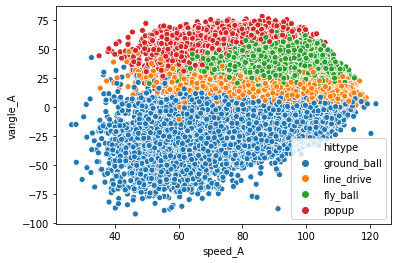

In [8]:
import seaborn as sns
sns.scatterplot(data=df_forspeed, x="speed_A", y="vangle_A", hue="hittype")

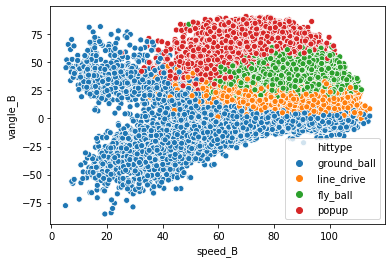

In [9]:
sns.scatterplot(data=df_forspeed, x="speed_B", y="vangle_B", hue="hittype")

Turns out system A is probably better based on its clearer distribution

## Step3: Take a look at all kinds of classification models, using hittype as dependent variable to see which model can best predict hittype. 

In [10]:
from sklearn.preprocessing import StandardScaler

df_forspeed = df_forspeed.dropna(axis=0)
to_scale = ['speed_A','vangle_A','speed_B','vangle_B']
df_forspeed[to_scale] = StandardScaler().fit_transform(df_forspeed[to_scale])

X1 = df_forspeed[to_scale]
Y1 = df_forspeed['hittype']

In [11]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, accuracy_score, log_loss, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


# scoring metrics
scoring = {
    'f1_weighted': 'f1_weighted',
    'accuracy': 'balanced_accuracy',
    'roc_auc': 'roc_auc_ovr_weighted',
    'neg_log_loss': 'neg_log_loss'
    }

# for results df
eval_cols = [
    'models',
    'F1 Score',
    'Balanced Accuracy',
    'ROC AUC',
    'Neg Log Loss'
    ]

# define classifier models
classifiers = [
    LogisticRegression(multi_class='multinomial', max_iter=10000),
    KNeighborsClassifier(n_neighbors=50),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
    ]

# classifier names
clf_names = [
    'Logistic Regression',
    'KNN',
    'SVM',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting',
    'XGBClassifier'
    ]

C:\Users\allen\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\allen\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
import time as time
import numpy as np

f1, acc, roc_auc, log_loss = [], [], [], []
for clf, clf_nm in zip(classifiers, clf_names):

    start = time.time()
    
    # cross-validate 5 times
    res = cross_validate(clf, X1, Y1, cv=5, scoring=scoring)
    results = pd.DataFrame(res)
    
    stop = time.time()

    print('Time to cross-validate %s = %0.3f min.' % (clf_nm, (stop - start) / 60))

    # save average scores
    f1.append(np.mean(results.test_f1_weighted))
    acc.append(np.mean(results.test_accuracy))
    roc_auc.append(np.mean(results.test_roc_auc))
    log_loss.append(np.mean(results.test_neg_log_loss))

# save results to df
model_eval = pd.DataFrame(data=zip(clf_names, f1, acc, roc_auc, log_loss),
                          columns=eval_cols)

display(model_eval)

Time to cross-validate Logistic Regression = 0.521 min.
Time to cross-validate KNN = 0.189 min.
Time to cross-validate SVM = 12.942 min.
Time to cross-validate Decision Tree = 0.117 min.
Time to cross-validate Random Forest = 1.932 min.
Time to cross-validate Gradient Boosting = 6.137 min.
Time to cross-validate XGBClassifier = 1.643 min.


,models,F1 Score,Balanced Accuracy,ROC AUC,Neg Log Loss
0,Logistic Regression,0.900400,0.870147,0.985261,-0.237083
1,KNN,0.902681,0.874242,0.984845,-0.286598
2,SVM,0.904596,0.878165,0.985841,-0.229317
3,Decision Tree,0.869808,0.835909,0.908584,-4.498305
4,Random Forest,0.899825,0.871575,0.983605,-0.330292
5,Gradient Boosting,0.904290,0.878427,0.986130,-0.227739
6,XGBClassifier,0.903555,0.879590,0.986208,-0.225514


It's the XGBClassifier that has the best performance. Thus I take a look at the feature importance in this model. 

In [13]:
model_xgbc = XGBClassifier()
X2 = df_forspeed[to_scale]
Y2 = df_forspeed['hittype']
model_xgbc.fit(X2, Y2)
for importance, name in sorted(zip(model_xgbc.feature_importances_, X2.columns),reverse=True):
 print(name, importance)  

vangle_B 0.49571997
vangle_A 0.4309041
speed_A 0.04313543
speed_B 0.030240556


From above it's a bit surprising that launch angle, especially measured by system B, is the most important feature in this model. But our goal is to predict exit velocity, I think system A is still the better one given that speed_A is more important than speed_B in this model.

## Step4: Perform SVD to check again which system is better and come up with the prediction for the exit velocity of each batter

In [14]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import Reader

df_forspeed_reserve = df_forspeed_reserve.dropna(axis=0, subset=['speed_A'])

reader = Reader(rating_scale=(0, 125))
data_a = Dataset.load_from_df(df_forspeed_reserve[['batter', 'pitcher', 'speed_A']], reader)

param_grid = {'n_factors': [50,100,200,400]}
gs_a = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, joblib_verbose=2)
gs_a.fit(data_a)

print(gs_a.best_score['rmse'], gs_a.best_score['mae'])
print(gs_a.best_params['rmse'], gs_a.best_params['mae'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


14.879184992328696 11.707908125074207
{'n_factors': 400} {'n_factors': 400}


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.9min finished


In [15]:
df_forspeed_reserve1 = df_forspeed_reserve1.dropna(axis=0, subset=['speed_B'])

data_b = Dataset.load_from_df(df_forspeed_reserve1[['batter', 'pitcher', 'speed_B']], reader)

gs_b = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, joblib_verbose=2 )
gs_b.fit(data_b)

print(gs_b.best_score['rmse'], gs_b.best_score['mae'])
print(gs_b.best_params['rmse'], gs_b.best_params['mae'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


21.053555050743814 16.56582814797363
{'n_factors': 400} {'n_factors': 400}


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.1min finished


Turns out system A is still the better one with smaller rmse and mae. The n_factors should be set at 400.

## Step5: Train the SVD model with exit velocity data from system A alone

In [16]:
from surprise.model_selection import train_test_split
train_svd, test_svd = train_test_split(data_a, test_size=.25)
model_svd = SVD(n_factors=400)
model_svd.fit(train_svd)

## Step6: Come up with a prediction using this SVD model. 

In [17]:
batter = []
predict = []
cols = ['batterid','prediction']
for i in range(1,817):
    batter.append(i)
    for j in range(1,646):
        predict.append(np.mean(model_svd.predict(i,j).est))

predictiontable = pd.DataFrame(data=zip(batter, predict),
                          columns=cols)
                               
display(predictiontable)

,batterid,prediction
0,1,86.472531
1,2,89.204811
2,3,90.218747
3,4,84.732594
4,5,93.556448
...,...,...
811,812,87.777504
812,813,84.939412
813,814,88.527537
814,815,90.481898


In [18]:
predictiontable['prediction'].describe()

count    816.000000
mean      88.618101
std        4.328894
min       69.344516
25%       86.192919
50%       88.688487
75%       91.122407
max      106.363642
Name: prediction, dtype: float64

The prediction is quite reasonable given that the mean(88.6) is nearly identical to that from system A(88.4). 

The reason I choose SVD as my model to predict batters performance is that we can take into account of all the possible matchups in this dataset. To me it seems like a good idea to represent the batters' exit velocity going forward. 

I only choose the data from the more reliable system A to perform the prediction. However there are some missing value in system A, which makes me wonder if the SVD model can perform better if I can map those missing values with data from system B. Thus I turn to randomforestregressor to see the relationship between exit velocity data from system A and exit velocity, launch angle from system B. I include launch angle data from system B because it contributes a lot in my XGBClassifier model. 

## Step7: RandomForestRegressor model building

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

df_forspeed_reserve2 = df_forspeed_reserve2.dropna(axis=0)

X_rfr = df_forspeed_reserve2[['speed_B','vangle_B']]
Y_rfr = df_forspeed_reserve2['speed_A']

X_rfr_train, X_rfr_test, Y_rfr_train, Y_rfr_test = train_test_split(X_rfr, Y_rfr, test_size=0.25)

rf = RandomForestRegressor()
rf.fit(X_rfr_train, Y_rfr_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## Step8: Prepare the data and mapping the missing value in system A

Extract those with missing value in 'speed_A' column

In [20]:
df_forspeed_reserve3_missa = df_forspeed_reserve3[df_forspeed_reserve3['speed_A'].isnull()==True]

From that drop the rows with missing value in 'speed_B' column, because we can't make prediction without data from system B

In [21]:
df_forspeed_reserve3_new = df_forspeed_reserve3_missa.dropna(axis=0, subset=['speed_B'])
print(df_forspeed_reserve3_new)

       batter  pitcher      hittype  speed_A  vangle_A    speed_B   vangle_B
9         672      405  ground_ball      NaN       NaN  28.367786 -28.315007
13        393      405        popup      NaN       NaN  59.326734  64.483031
19        448      518        popup      NaN       NaN  57.574755  66.346444
28        198      433        popup      NaN       NaN  89.726600  67.790938
34         88      222        popup      NaN       NaN  75.731310  67.965559
...       ...      ...          ...      ...       ...        ...        ...
73314     639      288  ground_ball      NaN       NaN  46.847703 -22.102549
73316     511      294  ground_ball      NaN       NaN  38.066303 -28.339097
73317     771      288  ground_ball      NaN       NaN  35.354232 -35.152147
73328     797      562  ground_ball      NaN       NaN  51.798600 -13.965296
73364     797      201  ground_ball      NaN       NaN  21.261171 -42.367025

[7029 rows x 7 columns]


Fit it into the randomforestregressor model I built earlier

In [22]:
X3 = df_forspeed_reserve3_new[['speed_B','vangle_B']]
df_forspeed_reserve3_new.loc[:,'speed_A'] = rf.predict(X3)
print(df_forspeed_reserve3_new)

       batter  pitcher      hittype    speed_A  vangle_A    speed_B   vangle_B
9         672      405  ground_ball  54.720024       NaN  28.367786 -28.315007
13        393      405        popup  63.113928       NaN  59.326734  64.483031
19        448      518        popup  61.385400       NaN  57.574755  66.346444
28        198      433        popup  90.411704       NaN  89.726600  67.790938
34         88      222        popup  78.460617       NaN  75.731310  67.965559
...       ...      ...          ...        ...       ...        ...        ...
73314     639      288  ground_ball  79.090168       NaN  46.847703 -22.102549
73316     511      294  ground_ball  63.177991       NaN  38.066303 -28.339097
73317     771      288  ground_ball  72.358719       NaN  35.354232 -35.152147
73328     797      562  ground_ball  77.748582       NaN  51.798600 -13.965296
73364     797      201  ground_ball  65.516227       NaN  21.261171 -42.367025

[7029 rows x 7 columns]


C:\Users\allen\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Extract the data which already has value in 'speed_A' column (I don't have to rely on the prediction from system B for these data because they are already the better one) 

In [23]:
df_forspeed_reserve3_rest = df_forspeed_reserve3[df_forspeed_reserve3['speed_A'].isnull()==False]
print(df_forspeed_reserve3_rest)

       batter  pitcher      hittype     speed_A   vangle_A     speed_B  \
0         393      405  ground_ball  110.987569   4.194081  103.842569   
1         366      405  ground_ball   60.098403 -54.652102   28.092203   
2         448      518   line_drive  102.757602  11.751851   97.846002   
3         140      518     fly_ball   61.952091  33.488154   59.389741   
4         521      518   line_drive  116.690861  22.700762  111.014561   
...       ...      ...          ...         ...        ...         ...   
73370     241      144  ground_ball   88.608999 -18.897550   60.251389   
73371     650      615  ground_ball  110.322436  -7.372974  106.029136   
73372     267      615     fly_ball   85.887085  44.557649   83.302545   
73373     797      615   line_drive   81.857912  19.235941   78.979512   
73374     304      603   line_drive  101.714189  16.345220   97.577289   

        vangle_B  
0       3.164307  
1     -28.324082  
2      11.658800  
3      32.798274  
4      23.164572

Combine the tables together

In [24]:
df_forspeed_reserve3_fin = df_forspeed_reserve3_rest.append(df_forspeed_reserve3_new)
print(df_forspeed_reserve3_fin)

       batter  pitcher      hittype     speed_A   vangle_A     speed_B  \
0         393      405  ground_ball  110.987569   4.194081  103.842569   
1         366      405  ground_ball   60.098403 -54.652102   28.092203   
2         448      518   line_drive  102.757602  11.751851   97.846002   
3         140      518     fly_ball   61.952091  33.488154   59.389741   
4         521      518   line_drive  116.690861  22.700762  111.014561   
...       ...      ...          ...         ...        ...         ...   
73314     639      288  ground_ball   79.090168        NaN   46.847703   
73316     511      294  ground_ball   63.177991        NaN   38.066303   
73317     771      288  ground_ball   72.358719        NaN   35.354232   
73328     797      562  ground_ball   77.748582        NaN   51.798600   
73364     797      201  ground_ball   65.516227        NaN   21.261171   

        vangle_B  
0       3.164307  
1     -28.324082  
2      11.658800  
3      32.798274  
4      23.164572

## Step9: Perform SVD with this brand new dataset again

In [25]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import Reader

data_fin = Dataset.load_from_df(df_forspeed_reserve3_fin[['batter', 'pitcher', 'speed_A']], reader)
gs_fin = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, joblib_verbose=2)
gs_fin.fit(data_fin)

print(gs_fin.best_score['rmse'], gs_fin.best_score['mae'])
print(gs_fin.best_params['rmse'], gs_fin.best_params['mae'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


15.909094475391946 12.5736465061106
{'n_factors': 400} {'n_factors': 400}


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.2min finished


Turns out it is worse than not mapping those missing value. But we can still take a look at the prediction since the data we put in are more complete and we take into account of system B in this model.

In [26]:
from surprise.model_selection import train_test_split
train_fin, test_fin = train_test_split(data_fin, test_size=.25)
model_fin = SVD(n_factors=400)
model_fin.fit(train_fin)

In [27]:
batter_fin = []
predict_fin = []

for i in range(1,817):
    batter_fin.append(i)
    for j in range(1,646):
        predict_fin.append(np.mean(model_fin.predict(i,j).est))

predictiontable_fin = pd.DataFrame(data=zip(batter_fin, predict_fin),
                          columns=cols)

display(predictiontable_fin)

,batterid,prediction
0,1,87.648908
1,2,80.112705
2,3,89.996793
3,4,85.135154
4,5,84.859453
...,...,...
811,812,82.420073
812,813,89.181063
813,814,84.669379
814,815,73.376652


In [28]:
predictiontable_fin['prediction'].describe()

count    816.000000
mean      86.937956
std        5.294740
min       57.855114
25%       84.225846
50%       87.344969
75%       90.117868
max      104.848546
Name: prediction, dtype: float64

The prediction is quite reasonable given that the mean(87.4) is similar to that in system A(88.4). 

# Conclusion: 
All in all I still think system A is better, whether by the scatterplot, the ability to predict hittype or SVD model, which is why I fit data from system A into the SVD model that predict the batters' performance. The reason I choose SVD as my model to predict batters performance is that we can take into account of all the possible matchups in this dataset. To me it seems like a good idea to represent the batters' exit velocity going forward. 